# Notebook for RL agent in trading

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
import torch
import matplotlib.pyplot as plt
from utils.agent import Agent
from utils.env import SimplifiedStockTradingEnv
from utils.dqn import DQN, DQN_with_Transformer
from utils.replay_buffer import ReplayBuffer
from utils.epsilon_greedy import EpsilonGreedy
from utils.lr_scheduler import MinimumExponentialLR

yf.pdr_override() 

## Yahoo API

In [2]:
# Replace 'AAPL' with the stock symbol you're interested in
stock_symbol = 'INTC'

### Define the pêriod

In [3]:
# Define the time period for historical data
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 1, 1)

### Get data from web

In [4]:
data = pdr.get_data_yahoo(stock_symbol, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,36.669998,37.160000,36.110001,36.360001,28.187449,23605600
2015-01-05,36.200001,36.450001,35.939999,35.950001,27.869606,32785000
2015-01-06,36.080002,36.230000,35.259998,35.279999,27.350197,30847600
2015-01-07,35.639999,36.070000,35.270000,36.020000,27.923866,27725200
2015-01-08,36.369999,37.000000,36.259998,36.689999,28.443274,31765400


### Save to CSV

In [5]:
data.to_csv('INTC.csv')

### Get downloaded data

In [6]:
data = pd.read_csv('INTC.csv')
WINDOW_SIZE = 30  
data['moving_average'] = data['Close'].rolling(window=WINDOW_SIZE).mean()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,moving_average
0,2015-01-02,36.669998,37.160000,36.110001,36.360001,28.187449,23605600,NaN
1,2015-01-05,36.200001,36.450001,35.939999,35.950001,27.869606,32785000,NaN
2,2015-01-06,36.080002,36.230000,35.259998,35.279999,27.350197,30847600,NaN
3,2015-01-07,35.639999,36.070000,35.270000,36.020000,27.923866,27725200,NaN
4,2015-01-08,36.369999,37.000000,36.259998,36.689999,28.443274,31765400,NaN


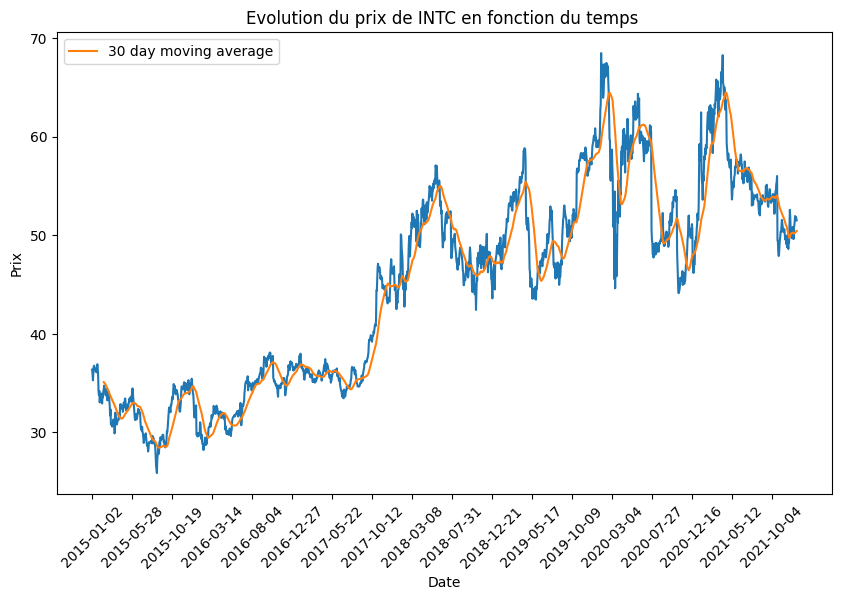

In [7]:

plt.figure(figsize=(10, 6))
plt.plot(data["Date"].to_numpy(), data['Close'].to_numpy(), linestyle='-')
plt.plot(data['moving_average'], label=f'{WINDOW_SIZE} day moving average')

plt.xlabel("Date")
plt.ylabel("Prix")

# do not plot all xticks
plt.xticks(data["Date"][::100], rotation=45)
plt.legend()
plt.title(f"Evolution du prix de {stock_symbol} en fonction du temps ")
plt.show()


## Implement DQNetwork

### Parameters

In [8]:
# Parameters
T = 5
price_list_size = 1
sync_period=30
lr = 1e-6 # 0.001
rb = 2000 # 2000
es = 0.82 # 0.82
em = 0.01 # 0.013
ed = 0.9 # 0.9675
num_episodes= 500 # 100
gamma=0.95 # 0.9
batch_size=128 # 128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device


'mps'

In [9]:
MODEL = "DQN"

# initializing a model and a target model
print("Creating Models ...")
if MODEL == "DQN":
    model = DQN(price_list_size, T+1, 1, 1, device).to(device)
    target_model = DQN(price_list_size, T+1, 1, 1, device).to(device)
elif MODEL == "DQN_with_Transformer":
    model = DQN_with_Transformer(price_list_size, T+1, 1, 1, device).to(device)
    target_model = DQN_with_Transformer(price_list_size, T+1, 1, 1, device).to(device)
print("... Models Created\n")

# initializing the optimizer, lr_scheduler and loss function
print("Creating Optimizer, LR Scheduler and Loss Function ...")
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, amsgrad=True)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=1e-8)
loss_fn = torch.nn.MSELoss()
print(f"... Optimizer (lr={optimizer.param_groups[0]['lr']}), LR Scheduler and Loss Function Created\n")

# initializing the replay buffer
print("Creating Replay Buffer ...")
replay_buffer = ReplayBuffer(rb)                                                                                                                    
print("... Replay Buffer Created\n")

# initializing the environment
print("Creating Environment ...")
env = SimplifiedStockTradingEnv(data, T=T)
print("... Environment Created\n")

# initializing the epsilon greedy strategy
print("Creating Epsilon Greedy Strategy ...")
epsilon_greedy = EpsilonGreedy(epsilon_start=es, epsilon_min=em, epsilon_decay=ed, env=env, model=model)
print("... Epsilon Greedy Strategy Created\n")

# initializing the agent
print("Creating Agent ...")
agent = Agent(env, model, MODEL,  target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created\n")

Creating Models ...
... Models Created

Creating Optimizer, LR Scheduler and Loss Function ...
... Optimizer (lr=1e-06), LR Scheduler and Loss Function Created

Creating Replay Buffer ...
... Replay Buffer Created

Creating Environment ...
... Environment Created

Creating Epsilon Greedy Strategy ...
... Epsilon Greedy Strategy Created

Creating Agent ...
... agent Created



### Find the best learning rate 

### Training Agent

In [10]:
episode_reward_list = agent.train(num_episodes, gamma, batch_size)

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'DQN' object has no attribute 'get_tgt_mask'

## Global results

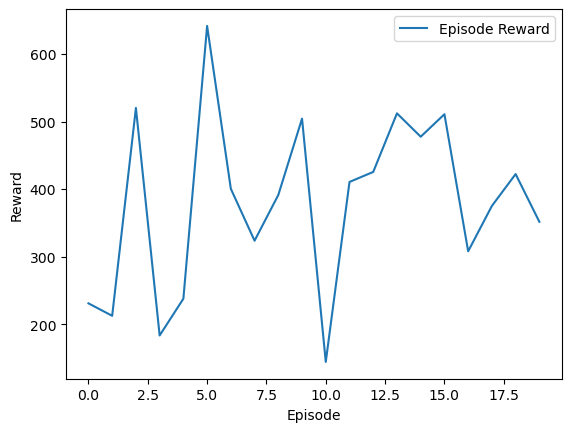

In [ ]:
plt.plot(episode_reward_list, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
# add parameters to the plot
plt.title(f"Stock= {stock_symbol}, model= {model.__class__.__name__}, gamma= {gamma}, b-s= {batch_size}, rb= {rb}, es= {es}, em= {em}, ed= {ed}, lr= {lr}, T= {T}")
plt.savefig("episode_reward.png")
plt.show()

## Results for the first episode

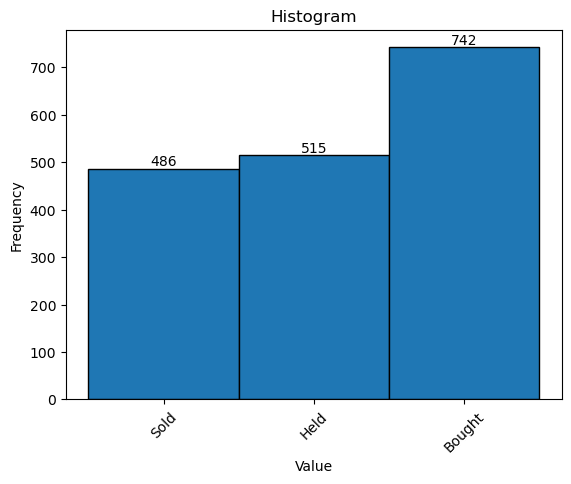

In [ ]:
num_bins = 3
bin_edges = np.linspace(min(agent.action_list[0]), max(agent.action_list[0]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[0], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()

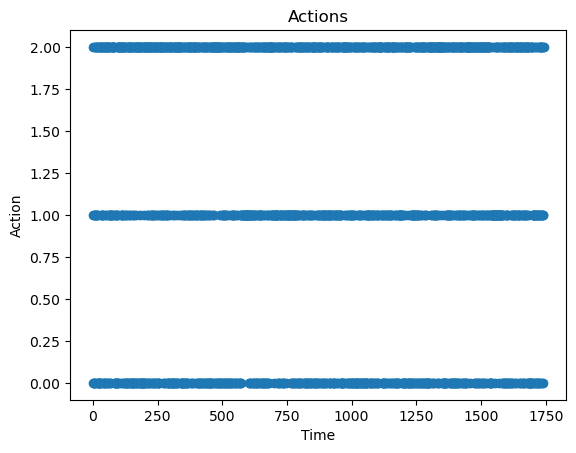

In [ ]:

plt.scatter(range(len(agent.action_list[0])), agent.action_list[0])
plt.title('Actions')
plt.xlabel('Time')
plt.ylabel('Action')
plt.show()


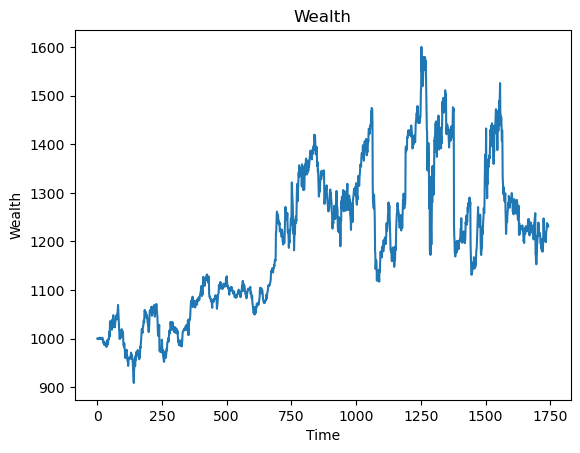

In [ ]:

plt.plot(agent.wealth_list[0])
plt.title('Wealth')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()


## Results for the last episode

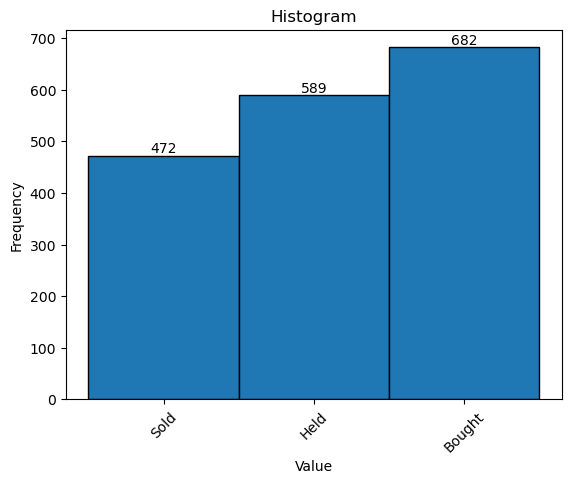

In [ ]:

bin_edges = np.linspace(min(agent.action_list[-1]), max(agent.action_list[-1]), num_bins + 1)
hist, _ = np.histogram(agent.action_list[-1], bins=bin_edges)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', edgecolor='black')
plt.xticks(bin_centers, ['Sold', 'Held', 'Bought'], rotation=45)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
for i in range(len(hist)):
    plt.text(bin_centers[i], hist[i], str(int(hist[i])), ha='center', va='bottom')
plt.show()


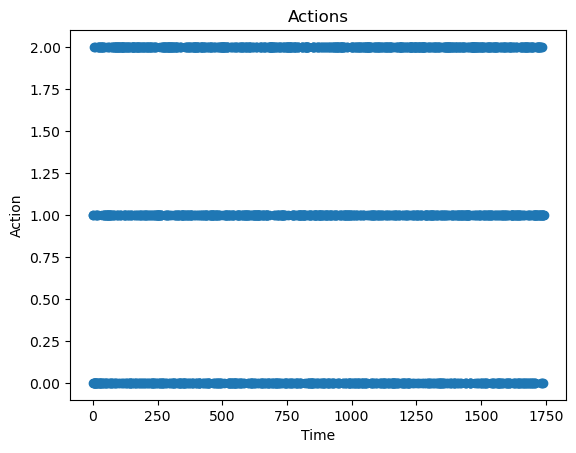

In [ ]:
plt.scatter(range(len(agent.action_list[-1])), agent.action_list[-1])
plt.title('Actions')
plt.xlabel('Time')
plt.ylabel('Action')
plt.show()


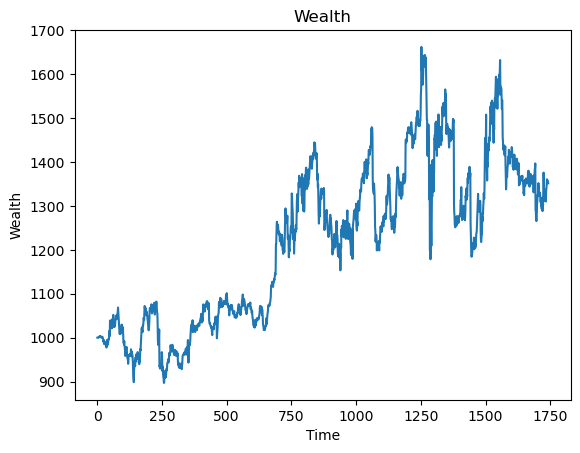

In [ ]:
plt.plot(agent.wealth_list[-1])
plt.title('Wealth')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

### Use final model

In [ ]:

# # import model model_1800.pt
# model_path = 'model_20.pt'

# model = DQN(price_list_size, T+1, 1, 1, device).to(device)
# target_model = DQN(price_list_size, T+1, 1, 1, device).to(device)

# model.load_state_dict(torch.load(model_path))
# target_model.load_state_dict(model.state_dict())


# test this model on the last 30 days of the data

# initializing the environment
print("Creating Environment ...")
env = SimplifiedStockTradingEnv(data, T=T)
print("... Environment Created\n")

# initializing the epsilon greedy strategy
print("Creating Epsilon Greedy Strategy ...")
epsilon_greedy = EpsilonGreedy(epsilon_start=0, epsilon_min=0, epsilon_decay=0, env=env, model=model)
print("... Epsilon Greedy Strategy Created\n")

# initializing the agent
print("Creating Agent ...")
agent = Agent(env, model, target_model, sync_period, optimizer, lr_scheduler, loss_fn, replay_buffer, epsilon_greedy)
print("... agent Created\n")

# test the model
reward_list, action_list, prop_list = agent.test(env)
reward_list = np.cumsum(np.array(reward_list))
final_reward = reward_list[-1]

print(f"Le reward obtenu à l'issue de tout est de {final_reward}")



Creating Environment ...
... Environment Created

Creating Epsilon Greedy Strategy ...
... Epsilon Greedy Strategy Created

Creating Agent ...
... agent Created

Action: 0, Reward: 0.00, Random Choice: False, Done: False
Action: 0, Reward: -0.01, Random Choice: False, Done: False
Action: 0, Reward: 0.02, Random Choice: False, Done: False
Action: 0, Reward: -0.05, Random Choice: False, Done: False
Action: 0, Reward: -0.03, Random Choice: False, Done: False
Action: 0, Reward: 0.06, Random Choice: False, Done: False
Action: 0, Reward: -0.01, Random Choice: False, Done: False
Action: 0, Reward: 0.04, Random Choice: False, Done: False
Action: 0, Reward: 0.02, Random Choice: False, Done: False
Action: 0, Reward: 0.03, Random Choice: False, Done: False
Action: 0, Reward: -0.03, Random Choice: False, Done: False
Action: 0, Reward: -0.00, Random Choice: False, Done: False
Action: 0, Reward: 0.01, Random Choice: False, Done: False
Action: 0, Reward: -0.05, Random Choice: False, Done: False
Actio

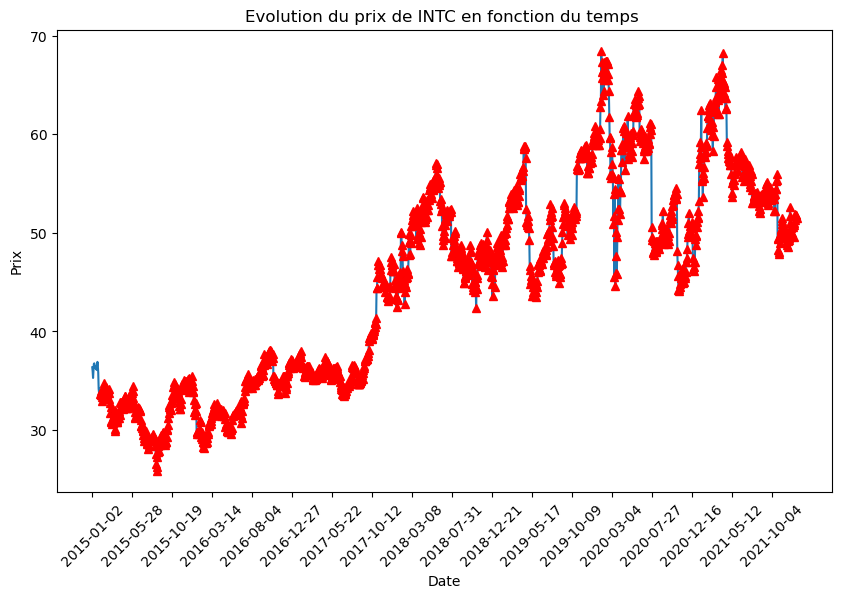

In [ ]:
# plot all stock evolution with a green triangle for action = 2 (buy) and a red triangle for action = 0 (sell)

plt.figure(figsize=(10, 6))
plt.plot(data["Date"].to_numpy(), data['Close'].to_numpy(), linestyle='-')

for i in range(len(action_list)):
    if action_list[i] == 2:
        plt.plot(data["Date"].iloc[i+T], data['Close'].iloc[i+T], 'g^')
    elif action_list[i] == 0:
        plt.plot(data["Date"].iloc[i+T], data['Close'].iloc[i+T], 'r^')

plt.xlabel("Date")
plt.ylabel("Prix")
plt.xticks(data["Date"][::100], rotation=45)
plt.title(f"Evolution du prix de {stock_symbol} en fonction du temps ")
plt.show()

